<a href="https://colab.research.google.com/github/arvindpandey4/BridgeLabz-Training-Indexnine/blob/feature%2Fai_ml/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q kagglehub

import kagglehub
import os

path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)
print("Files in directory:", os.listdir(path))

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset
Files in directory: ['PetImages']


In [4]:
!pip install -q kagglehub opencv-python matplotlib seaborn tqdm scikit-learn tensorflow

In [5]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import warnings

warnings.filterwarnings('ignore')

In [6]:
DATASET_DIR = path
PET_IMAGES_DIR = os.path.join(DATASET_DIR, "PetImages")

if not os.path.exists(PET_IMAGES_DIR):
    if os.path.exists(os.path.join(DATASET_DIR, "Cat")):
        PET_IMAGES_DIR = DATASET_DIR
    else:
        print(f"Warning: Could not find PetImages or Cat/Dog folders in {DATASET_DIR}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
print(f"Dataset Directory: {PET_IMAGES_DIR}")

Dataset Directory: /kaggle/input/dog-and-cat-classification-dataset/PetImages


In [7]:
import shutil

WRITABLE_DIR = "./temp_pet_images"

print(f"Copying data from {PET_IMAGES_DIR} to {WRITABLE_DIR}...")
print("This may take a minute or two...")

if os.path.exists(WRITABLE_DIR):
    shutil.rmtree(WRITABLE_DIR)

shutil.copytree(PET_IMAGES_DIR, WRITABLE_DIR)
print("Copy complete!")

PET_IMAGES_DIR = WRITABLE_DIR
print(f"New Dataset Directory (Writable): {PET_IMAGES_DIR}")

Copying data from /kaggle/input/dog-and-cat-classification-dataset/PetImages to ./temp_pet_images...
This may take a minute or two...
Copy complete!
New Dataset Directory (Writable): ./temp_pet_images


In [8]:
import os
import tensorflow as tf
from pathlib import Path

PET_IMAGES_DIR = "./temp_pet_images"

print(f"Cleaning data in: {PET_IMAGES_DIR}")

def remove_bad_images(dataset_path):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
    p = Path(dataset_path)

    removed_count = 0
    checked_count = 0

    print(f"Scanning {dataset_path} for corrupt files using TensorFlow decoder...")

    for filepath in p.rglob('*'):
        if filepath.suffix.lower() in image_extensions:
            checked_count += 1
            try:
                file_bytes = tf.io.read_file(str(filepath))

                if tf.size(file_bytes) == 0:
                     raise Exception("Empty file")

                _ = tf.io.decode_image(file_bytes, channels=3, expand_animations=False)

            except Exception as e:
                print(f"❌ Deleting corrupted file: {filepath.name}")
                try:
                    os.remove(filepath)
                    removed_count += 1
                except OSError as os_err:
                    print(f"Could not delete {filepath.name}: {os_err}")

    print(f"\nScan complete.")
    print(f"Total checked: {checked_count}")
    print(f"Total removed: {removed_count}")

if os.path.exists(PET_IMAGES_DIR):
    remove_bad_images(PET_IMAGES_DIR)
else:
    print(f"Error: Directory {PET_IMAGES_DIR} does not exist. Make sure you ran the copy step.")

Cleaning data in: ./temp_pet_images
Scanning ./temp_pet_images for corrupt files using TensorFlow decoder...
❌ Deleting corrupted file: 10404.jpg
❌ Deleting corrupted file: 4351.jpg
❌ Deleting corrupted file: 2494.jpg
❌ Deleting corrupted file: 11912.jpg
❌ Deleting corrupted file: 9500.jpg
❌ Deleting corrupted file: 2317.jpg
❌ Deleting corrupted file: 11233.jpg

Scan complete.
Total checked: 24998
Total removed: 7


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    PET_IMAGES_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    PET_IMAGES_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 24991 files belonging to 2 classes.
Using 19993 files for training.
Found 24991 files belonging to 2 classes.
Using 4998 files for validation.


In [10]:
preprocess = lambda x, y: (preprocess_input(x), y)

train_ds_pre = train_ds.map(preprocess)
val_ds_pre = val_ds.map(preprocess)

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
resnet.trainable = False

print("ResNet50 Model Loaded.")

def extract_features(dataset, steps=None):
    features_list = []
    labels_list = []

    print("Extracting features...")
    for x, y in tqdm(dataset):
        feats = resnet.predict(x, verbose=0)
        features_list.append(feats)
        labels_list.append(y.numpy())

    return np.vstack(features_list), np.concatenate(labels_list)

print("Processing Training Data...")
X_train, y_train = extract_features(train_ds_pre)

print("Processing Validation Data...")
X_test, y_test = extract_features(val_ds_pre)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ResNet50 Model Loaded.
Processing Training Data...
Extracting features...


100%|██████████| 625/625 [02:22<00:00,  4.38it/s]


Processing Validation Data...
Extracting features...


100%|██████████| 157/157 [00:34<00:00,  4.52it/s]

Training Features Shape: (19993, 2048)
Testing Features Shape: (4998, 2048)


In [11]:
svm_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1, warm_start=True, random_state=SEED)

epochs = 20
history = {'accuracy': [], 'val_accuracy': [], 'loss': []}

print("Starting SVM Training...")
classes = np.unique(y_train)

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    for i in range(0, len(X_train), BATCH_SIZE):
        X_batch = X_train_shuffled[i:i+BATCH_SIZE]
        y_batch = y_train_shuffled[i:i+BATCH_SIZE]
        svm_clf.partial_fit(X_batch, y_batch, classes=classes)

    train_pred = svm_clf.predict(X_train)
    test_pred = svm_clf.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Training Accuracy: {train_acc:.4f} | Validation Accuracy: {test_acc:.4f}")

print("Training Complete.")

Starting SVM Training...
Epoch 1/20 | Training Accuracy: 0.9897 | Validation Accuracy: 0.9898
Epoch 2/20 | Training Accuracy: 0.9889 | Validation Accuracy: 0.9860
Epoch 3/20 | Training Accuracy: 0.9936 | Validation Accuracy: 0.9894
Epoch 4/20 | Training Accuracy: 0.9932 | Validation Accuracy: 0.9890
Epoch 5/20 | Training Accuracy: 0.9954 | Validation Accuracy: 0.9898
Epoch 6/20 | Training Accuracy: 0.9953 | Validation Accuracy: 0.9874
Epoch 7/20 | Training Accuracy: 0.9964 | Validation Accuracy: 0.9886
Epoch 8/20 | Training Accuracy: 0.9950 | Validation Accuracy: 0.9898
Epoch 9/20 | Training Accuracy: 0.9969 | Validation Accuracy: 0.9894
Epoch 10/20 | Training Accuracy: 0.9968 | Validation Accuracy: 0.9882
Epoch 11/20 | Training Accuracy: 0.9981 | Validation Accuracy: 0.9904
Epoch 12/20 | Training Accuracy: 0.9907 | Validation Accuracy: 0.9846
Epoch 13/20 | Training Accuracy: 0.9967 | Validation Accuracy: 0.9892
Epoch 14/20 | Training Accuracy: 0.9938 | Validation Accuracy: 0.9864
Epoc

Generating 20 random predictions using 'resnet'...


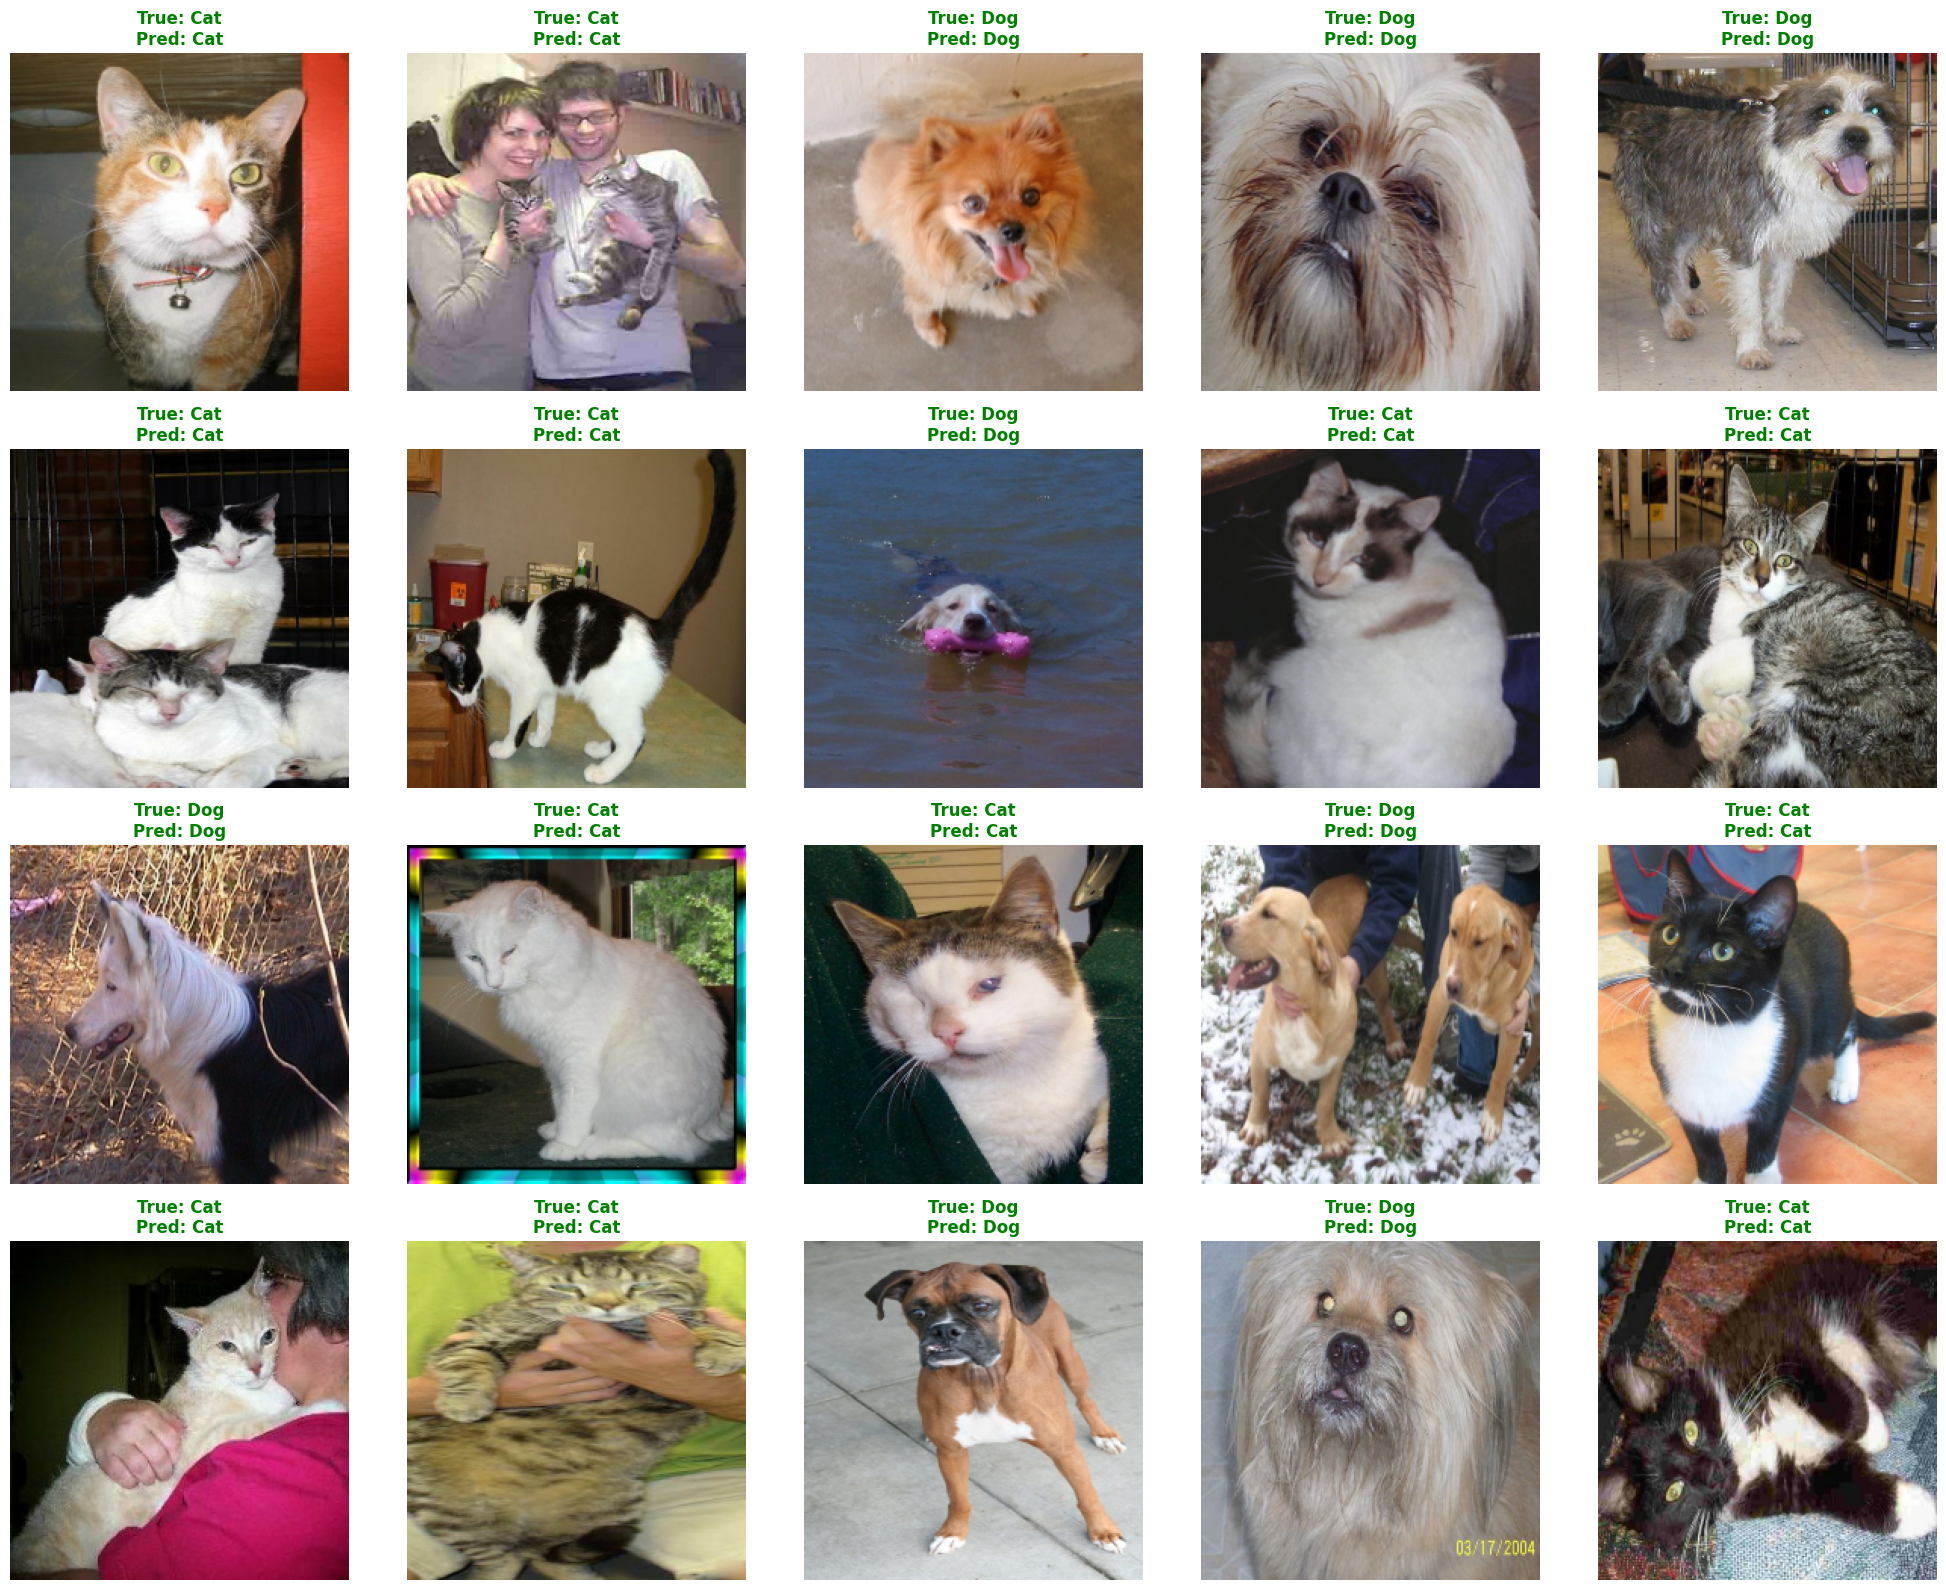

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

if 'val_ds' not in globals():
    print("Reloading validation dataset for visualization...")
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        PET_IMAGES_DIR,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(224, 224),
        batch_size=32
    )

def visualize_random_predictions(dataset, feature_model, classifier, num_samples=20):
    class_names = dataset.class_names
    plt.figure(figsize=(20, 16))

    random_batch = dataset.unbatch().shuffle(buffer_size=500).batch(num_samples).take(1)

    for images, labels in random_batch:
        input_imgs = tf.keras.applications.resnet50.preprocess_input(tf.cast(images, tf.float32))

        features = feature_model.predict(input_imgs, verbose=0)

        preds = classifier.predict(features)

        for i in range(len(images)):
            ax = plt.subplot(4, 5, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))

            true_label = class_names[int(labels[i])]
            pred_label = class_names[int(preds[i])]

            color = 'green' if true_label == pred_label else 'red'

            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontweight='bold')
            plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Generating 20 random predictions using 'resnet'...")
visualize_random_predictions(val_ds, resnet, svm_clf, num_samples=20)

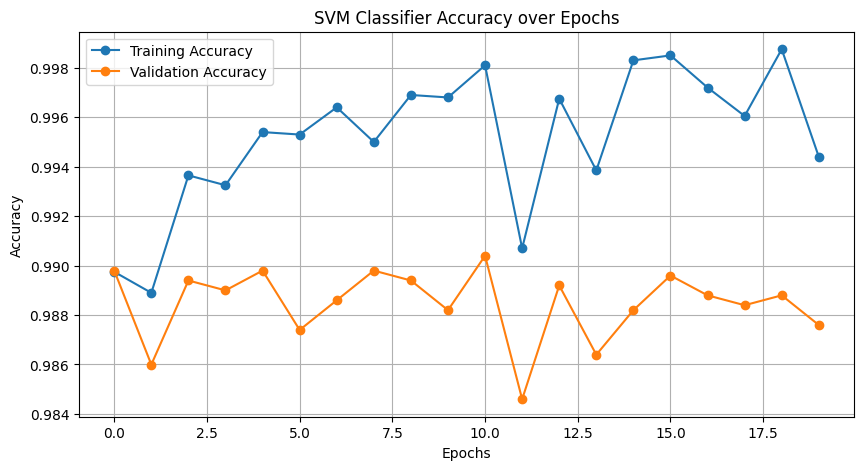

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('SVM Classifier Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
print("Classification Report:")
print(classification_report(y_test, svm_clf.predict(X_test), target_names=['Cat', 'Dog']))

Classification Report:
              precision    recall  f1-score   support

         Cat       1.00      0.98      0.99      2460
         Dog       0.98      1.00      0.99      2538

    accuracy                           0.99      4998
   macro avg       0.99      0.99      0.99      4998
weighted avg       0.99      0.99      0.99      4998

